## Emojify
This is a proof of concept for creating an emoji NLP word represntational model, similar to what’s on your phone. The model will leverage a pretrained GloVe word representational word embedding layer.  The emoji representations / classifications are kept simple with only 5 classes.

In [1]:
# load libraries
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

%matplotlib inline

Using TensorFlow backend.


In [2]:
# set the random seed
seed = 7
np.random.seed(seed)

In [3]:
# load data
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/test.csv')

In [4]:
# determine max length of training input sequences
maxLen = len(max(X_train, key=len).split())
print("Max length is: " + str(maxLen))

Max length is: 10


In [5]:
# convert outputs to one-hot-vectors
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [6]:
# review one-hot output
index = 75
print(Y_train[index], "is converted to one hot vector", Y_oh_train[index])

2 is converted to one hot vector [0. 0. 1. 0. 0.]


In [7]:
# load the Glove word embedding matrix
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [8]:
# review the embedding matrix data
word = "football"
index = 289846
print("The index of", word, "in the vocabulary is", word_to_index[word])
print("The", str(index) + "th word in the vocabulary is", index_to_word[index])
print("The word index for baseball is:", word_to_index['baseball'])

The index of football in the vocabulary is 151266
The 289846th word in the vocabulary is potatos
The word index for baseball is: 69714


In [9]:
# Converts an array of sentences (strings) into an array of indices corresponding to words in the sentance.
# The output shape should be such that it can be given to Embedding().
def sentences_to_indices(X, word_to_index, max_len): 
    """    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    m = X.shape[0] # number of training examples

    # Initialize X_indices as a numpy matrix of zeros
    X_indices = np.zeros((m, max_len))

   
    for i in range(m): 
        # Convert the ith training sentence in lower case and split is into words
        sentence_words = (X[i].lower()).split()

        j = 0

        
        for w in sentence_words:
            # Set the entry of X_indices to the index of the correct word
            X_indices[i, j] = word_to_index[w]
            j += 1

    return X_indices
    

In [10]:
# validate function
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [11]:
# Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)
    
    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1   # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]  # define dimensionality of your GloVe word vector
   
    # Initialize the embedding matrix as an array of zeros of shape 
    # (vocab_len, dimensions of word emb_matrix = np.zeros((vocab_len, emb_dim))
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the index
    for word, index in word_to_index.items(): 
        emb_matrix[index, :] = word_to_vec_map[word]
    
    # Define Keras embedding layer with the correct output/input sizes, make it trainable
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    
    # Build the embedding layer, it is required before setting the weights of the embedding layer
    embedding_layer.build((None,))
    
    # Set the pretrained weights of the embedding layer to the embedding matrix. Your layer is now .
    embedding_layer.set_weights([emb_matrix]) 
    
    return embedding_layer

In [12]:
# create keras embedding layer
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
# confirm weights
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [13]:
# Main function creating the model's graph
def Emojify (input_shape, word_to_vec_map, word_to_index):
    """    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector repr
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)
    """    

    # Define sentence_indices as the input
    sentence_indices = Input(input_shape, dtype='int32')

    # Create the embedding layer with pretrained GloVe vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    # Propagate sentence_indices through your embedding layerto get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    L1 = Bidirectional(LSTM(128, return_sequences=True), merge_mode='concat')(embeddings)
    L2 = Bidirectional(LSTM(128, return_sequences=False), merge_mode='concat')(L1)
    D1 = Dropout(0.4)(L2)
    L3 = Dense(512)(D1) 
    L4 = Dense(5)(L3)
    out = Activation('softmax')(L4)
    model = Model(inputs=sentence_indices, outputs=out)
    
    return model

In [14]:
# create the model
model = Emojify((maxLen,), word_to_vec_map, word_to_index)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 256)           183296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
__________

In [15]:
# define X & Y values
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)

In [16]:
# fit the model
history = model.fit(X_train_indices, Y_train_oh, epochs=30, batch_size=32, shuffle=True, validation_data=(X_test_indices, Y_test_oh)).history

Train on 132 samples, validate on 56 samples
Epoch 1/30
132/132 [==============================] - 2s 14ms/step - loss: 1.5732 - acc: 0.2500 - val_loss: 1.4718 - val_acc: 0.4107
Epoch 2/30
132/132 [==============================] - 0s 4ms/step - loss: 1.4501 - acc: 0.3864 - val_loss: 1.3958 - val_acc: 0.4821
Epoch 3/30
132/132 [==============================] - 1s 4ms/step - loss: 1.2673 - acc: 0.5076 - val_loss: 1.1970 - val_acc: 0.5536
Epoch 4/30
132/132 [==============================] - 1s 4ms/step - loss: 0.9975 - acc: 0.7348 - val_loss: 0.9581 - val_acc: 0.6429
Epoch 5/30
132/132 [==============================] - 1s 4ms/step - loss: 0.7020 - acc: 0.7652 - val_loss: 0.8172 - val_acc: 0.6964
Epoch 6/30
132/132 [==============================] - 1s 5ms/step - loss: 0.5981 - acc: 0.7803 - val_loss: 0.6485 - val_acc: 0.7500
Epoch 7/30
132/132 [==============================] - 1s 5ms/step - loss: 0.4675 - acc: 0.8106 - val_loss: 0.6191 - val_acc: 0.7679
Epoch 8/30
132/132 [==========

In [17]:
# evaluate model on test set
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print("Test accuracy = ", acc)

56/56 [==============================] - 0s 518us/step
Test accuracy =  0.8214285799435207


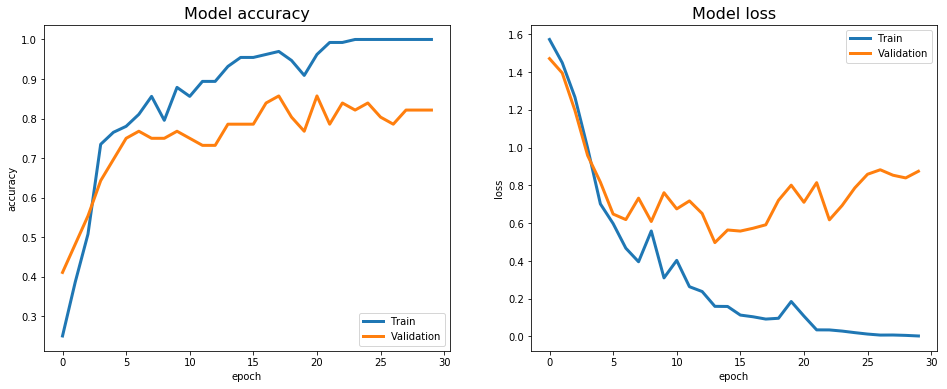

In [18]:
# plot the model loss and accuracy
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history['acc'], label='Train', linewidth=3)
axis1.plot(history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# summarize history for loss
axis2.plot(history['loss'], label='Train', linewidth=3)
axis2.plot(history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [19]:
# test on new inputs - positive
x_test = np.array(["I want dinner"])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] + ' ' + label_to_emoji(np.argmax(model.predict(X_test_indices))))

I want dinner 🍴


In [20]:
# test on new inputs - positive
x_test = np.array(["What a beautiful day"])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] + ' ' + label_to_emoji(np.argmax(model.predict(X_test_indices))))

What a beautiful day 😄


In [22]:
# test on new inputs - negative
x_test = np.array(["I am not happy"])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] + ' ' + label_to_emoji(np.argmax(model.predict(X_test_indices))))

I am not happy 😞
